Model loaded successfully!
Total parameters: 71967905


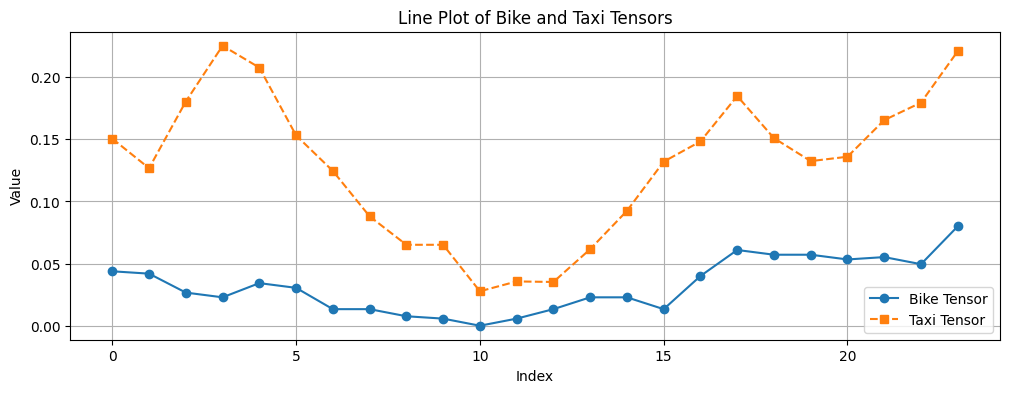

数据已保存到 bike_taxi_tensors.csv


In [20]:
import json
import time
import os
import yaml
import argparse
import numpy as np
import torch
import functools
import queue
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from utils.mdtp import MyDataset_nstponline
from models.model import Net_timesnet_sample_onetimesnet
from models.smoe_config import SpatialMoEConfig
from models.gate import SpatialLatentTensorGate2d
from IPython.display import display

# 设置参数
class Args:
    device = 'cuda:0'
    batch_size = 16
    window_size = 24
    pred_size = 4
    node_num = 231
    in_features = 2
    out_features = 16
    lstm_features = 256
    learning_rate = 0.001
    weight_decay = 0.0001
    epochs = 20
    gradient_clip = 5
    pad = False
    bike_base_path = './data/bike'
    taxi_base_path = './data/taxi'
    seed = 99
    save = '/home_nfs/haitao/data/web_host_network/mdtp_moe/log_2024-12-22_22-54-12/best_model.pth'

args = Args()
config = yaml.safe_load(open('config.yml'))

def custom_collate_fn(batch):
    return batch

# 加载数据
bikevolume_test_save_path = os.path.join(args.bike_base_path, 'BV_test.npy')
taxivolume_test_save_path = os.path.join(args.taxi_base_path, 'TV_test.npy')

bike_test_data = MyDataset_nstponline(bikevolume_test_save_path, args.window_size, args.batch_size, args.pred_size)
taxi_test_data = MyDataset_nstponline(taxivolume_test_save_path, args.window_size, args.batch_size, args.pred_size)

bike_test_loader = DataLoader(
    dataset=bike_test_data,
    batch_size=None,
    shuffle=False,
    pin_memory=True,
    collate_fn=custom_collate_fn,
    num_workers=0,
)
taxi_test_loader = DataLoader(
    dataset=taxi_test_data,
    batch_size=None,
    shuffle=False,
    pin_memory=True,
    collate_fn=custom_collate_fn ,
    num_workers=0,
)

# 配置模型
base_smoe_config = SpatialMoEConfig(
    in_planes=2,
    out_planes=16,
    num_experts=32,
    gate_block=functools.partial(SpatialLatentTensorGate2d, node_num=231),
    save_error_signal=True,
    dampen_expert_error=False,
    unweighted=False,
    block_gate_grad=True,
)

model = Net_timesnet_sample_onetimesnet(args.batch_size, args.window_size, args.node_num, 
                                        args.in_features, args.out_features, args.lstm_features, 
                                        base_smoe_config, args.pred_size)

device = torch.device(args.device)
model.to(device)
model.load_state_dict(torch.load(args.save), strict=False)
model.eval()
print('Model loaded successfully!')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')

# 运行测试
for iter, (bike_node, taxi_node) in enumerate(zip(bike_test_loader, taxi_test_loader)):
    bike_in_shots, _ = bike_node
    taxi_in_shots, _ = taxi_node

    bike_in_shots = bike_in_shots.to(device)
    taxi_in_shots = taxi_in_shots.to(device)

    # 取某个固定索引的时间序列数据
    a = 140
    tensor1 = bike_in_shots[0, :, a, 0]
    tensor2 = taxi_in_shots[0, :, a, 0]

    # 创建 x 轴索引
    x = range(len(tensor1))

    # 绘制折线图，调整为扁长形
    plt.figure(figsize=(12, 4))  # 宽 12，高 4，调整形状
    plt.plot(x, tensor1.cpu().numpy(), marker='o', linestyle='-', label='Bike Tensor')
    plt.plot(x, tensor2.cpu().numpy(), marker='s', linestyle='--', label='Taxi Tensor')

    # 添加标题和标签
    plt.title("Line Plot of Bike and Taxi Tensors")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

    # 显示图像
    plt.show()
    
    # 取某个固定索引的时间序列数据
    tensor1 = tensor1.cpu().numpy()
    tensor2 = tensor2.cpu().numpy()

    # 创建 DataFrame 并保存 CSV
    df = pd.DataFrame({
        "Index": list(range(len(tensor1))),
        "Bike Tensor": tensor1,
        "Taxi Tensor": tensor2
    })
    csv_filename = "bike_taxi_tensors.csv"
    df.to_csv(csv_filename, index=False)
    print(f"数据已保存到 {csv_filename}")
    # 只展示一次
    break